<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/FinalProjectCodeChangeSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
# import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt
import itertools


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# All the classes of emotions we have
classeses = []
for i in os.listdir('C:/Users/Admin/Desktop/MIE1517_Project/data'):
    if i!=5:
        classeses.append(i)
classeses

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutrality',
 'sadness',
 'surprise']

In [3]:
# Data loading
classes = os.listdir('C:/Users/Admin/Desktop/MIE1517_Project/data')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('C:/Users/Admin/Desktop/MIE1517_Project/data', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_pil = cv2.imread(img_path)

            if img_pil is None:
                print("Error loading image:", img_path)
                continue
            #Append the original image and its label to the list
            features.append(np.array(img_pil))
            labels.append(label)

create_train()
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 anger: 890 images
Label 1 contempt: 208 images
Label 2 disgust: 439 images
Label 3 fear: 570 images
Label 4 happiness: 1406 images
Label 5 neutrality: 524 images
Label 6 sadness: 746 images
Label 7 surprise: 775 images


In [4]:
# Brief visualization of the dataset
def plot_first_n_images(images, labels, classes, n=5):
    num_unique_labels = len(np.unique(labels))  # Get the number of unique labels
    fig, axes = plt.subplots(num_unique_labels, n, figsize=(n*2, num_unique_labels*2))

    # Initialize a dictionary to store image indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Plot 'n' images for each unique label
    for label_idx, label in enumerate(np.unique(labels)):
        indices = label_indices[label][:n]  # Get the first 'n' indices for this label
        for img_idx, img_index in enumerate(indices):
            axes[label_idx, img_idx].imshow(images[img_index], cmap='gray')
            axes[label_idx, img_idx].set_title(f"Label: {classes[label]}")
            axes[label_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.show()

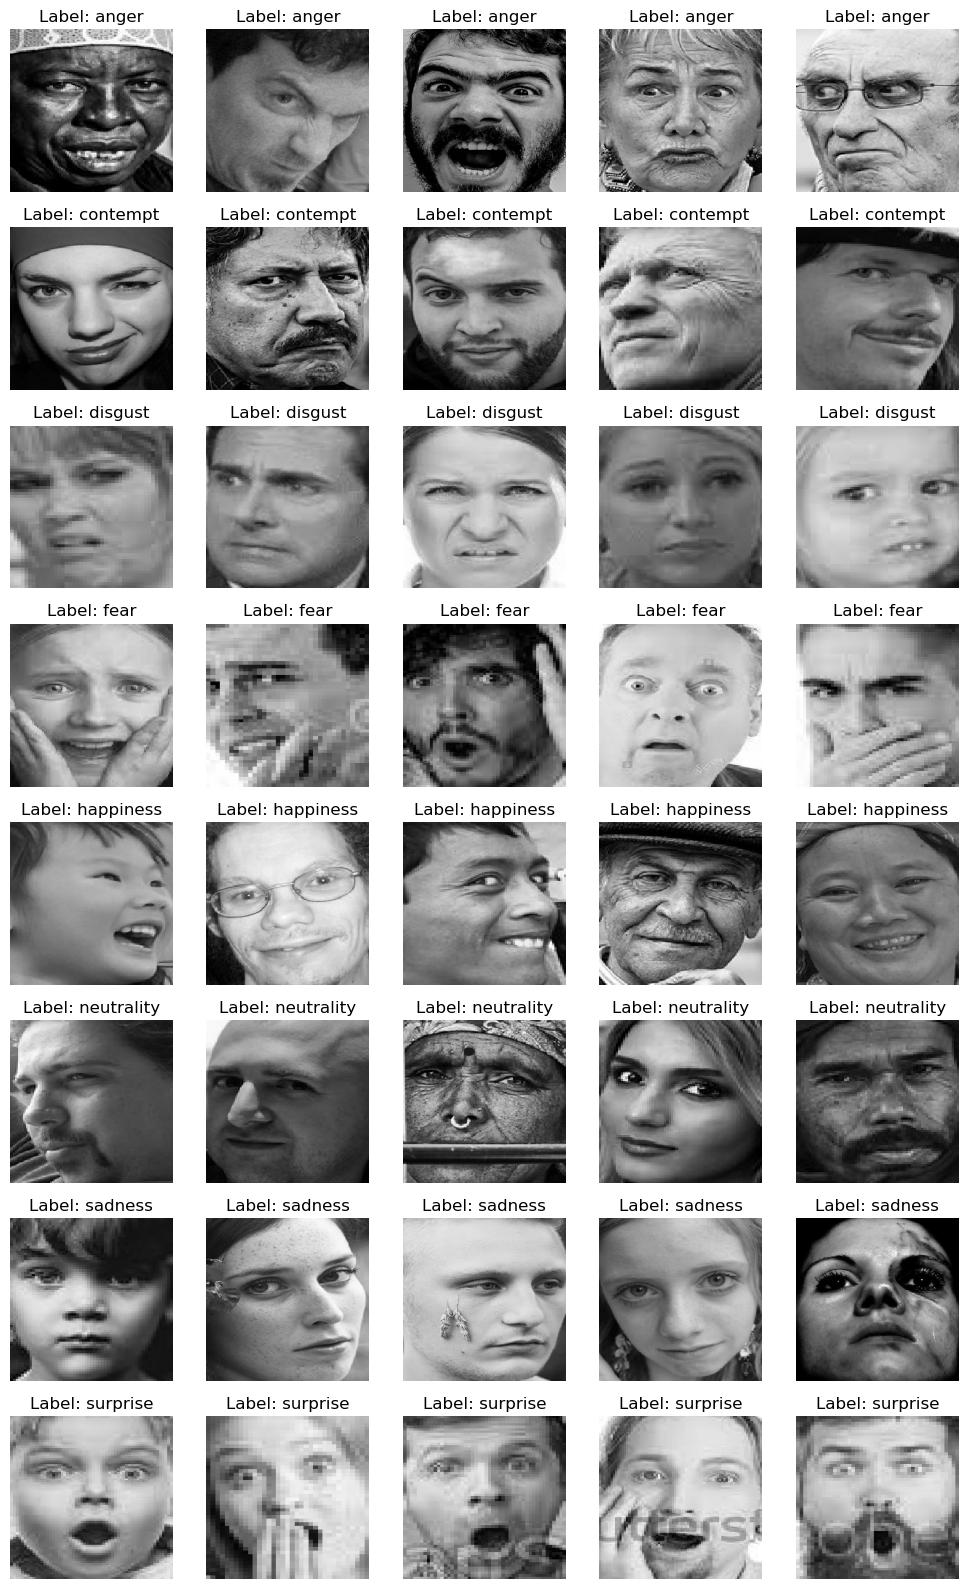

In [ ]:
# Brief visualization of the dataset
plot_first_n_images(features, labels, classeses, n=5)

In [5]:
#Data processing performed
# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

In [6]:
# Your existing code to load images
features_or = []
labels_or = []
train_data_or = []
failed_indices = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('C:/Users/Admin/Desktop/MIE1517_Project/data', photo)
        label = i  # Use the index of the class as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Convert the image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE to improve the contrast locally
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray_clahe = clahe.apply(gray)

            # Detect faces in the CLAHE preprocessed image
            faces = detector(gray_clahe, 1)

            # If no faces are detected with CLAHE, try standard histogram equalization
            if len(faces) == 0:
                gray_eq = cv2.equalizeHist(gray)
                faces = detector(gray_eq, 1)
                image_to_use = gray_eq
            else:
                image_to_use = gray_clahe

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(image_to_use, face)
                combined_region = extract_and_combine_regions(image_to_use, landmarks)

                # Append the combined image and its label to the list
                features_or.append(combined_region)  # Append the combined region
                labels_or.append(label)

                train_data_or.append([combined_region, label])
            else:
                failed_indices.append(i)

create_images()
# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label} {classeses[label]}: {count} images")

Label 0 anger: 585 images
Label 1 contempt: 142 images
Label 2 disgust: 292 images
Label 3 fear: 372 images
Label 4 happiness: 896 images
Label 5 neutrality: 419 images
Label 6 sadness: 448 images
Label 7 surprise: 600 images


In [38]:
# Extract sadness and happiness
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing

# Define the labels you want to extract
desired_labels = [4, 6]
for i in desired_labels:
  print("Class: ", classeses[i])
# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Class:  happiness
Class:  sadness
Label 4 happiness: 896 images
Label 6 sadness: 448 images
Filtered Features Shape: (1344, 224, 224)
Filtered Labels Shape: (1344,)


In [39]:
# Two class
labels_filtered = np.array(labels_filtered)
# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 4] = 0
labels_filtered[labels_filtered == 6] = 1
np.unique(labels_filtered)

array([0, 1])

In [7]:
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])
# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

def split_and_prepare_dataset(features, labels, transform, train_percent=0.60, val_percent=0.20):
    # Use Counter to get the count of each label in the dataset
    label_counts = Counter(labels)

    # Dictionary to store the indices for each label
    label_indices = defaultdict(list)

    # Populate the dictionary with indices of images for each label
    for index, label in enumerate(labels):
        label_indices[label].append(index)

    # Dictionary to store the indices for each set
    train_indices = []
    val_indices = []
    test_indices = []

    # Iterate over unique labels and distribute their indices among train, val, and test sets
    for label, indices in label_indices.items():
        label_size = len(indices)
        train_size = int(label_size * train_percent)
        val_size = int(label_size * val_percent)

        # Add indices to each set
        train_indices.extend(indices[:train_size])
        val_indices.extend(indices[train_size:(train_size + val_size)])
        test_indices.extend(indices[(train_size + val_size):])

    # Create Subset datasets based on the sampled indices
    train_dataset = prepare_dataset(features[train_indices], labels[train_indices], transform)
    val_dataset = prepare_dataset(features[val_indices], labels[val_indices], transform)
    test_dataset = prepare_dataset(features[test_indices], labels[test_indices], transform)

    return train_dataset, val_dataset, test_dataset

In [40]:
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

In [23]:
# # Prepare datasets for eyes, eyebrows, and mouth
# combined_dataset = prepare_dataset(features_filtered, labels_filtered, transform)
# # Split each dataset into training, validation, and test sets
# combined_train_dataset, combined_val_dataset, combined_test_dataset = split_dataset(combined_dataset)

In [28]:
# Check the length of each dataset
train_length = len(combined_train_dataset)
val_length = len(combined_val_dataset)
test_length = len(combined_test_dataset)

print(f"Training set length: {train_length} samples")
print(f"Validation set length: {val_length} samples")
print(f"Test set length: {test_length} samples")

Training set length: 805 samples
Validation set length: 268 samples
Test set length: 271 samples


In [41]:
train_labels = combined_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the training dataset
label_counts_train = Counter(train_labels)
# Print the counts for each label
for label, count in label_counts_train.items():
    print(f"Label {label} : {count} images")

Label 0 : 537 images
Label 1 : 268 images


In [8]:
# Data Augmentation in train data
# Define the augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # Flip with a probability of 1 (always flip)
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
])

def balance_dataset_with_augmentation(original_train_dataset, augmentation_transforms):
    # Count the number of images for each unique label in the training set
    label_counts_train = Counter(original_train_dataset.tensors[1].numpy())

    # Determine the maximum count among all labels
    max_count = max(label_counts_train.values())

    # Apply data augmentation to balance the dataset
    augmented_images = []
    augmented_labels = []

    for label, count in label_counts_train.items():
        # Calculate the number of augmentations needed for each label
        augmentations_needed = max_count - count

        # Filter images and labels for the current label
        label_indices = [i for i, l in enumerate(original_train_dataset.tensors[1].numpy()) if l == label]
        label_images = original_train_dataset.tensors[0][label_indices]
        label_labels = original_train_dataset.tensors[1][label_indices]

        # Apply data augmentation to reach the desired count
        for _ in range(augmentations_needed):
            random_index = np.random.choice(len(label_images))
            augmented_image = augmentation_transforms(label_images[random_index])
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    # Convert augmented data to tensors
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)

    # Combine the original and augmented data
    balanced_train_dataset = TensorDataset(torch.cat([original_train_dataset.tensors[0], augmented_images]),
                                           torch.cat([original_train_dataset.tensors[1], augmented_labels]))

    return balanced_train_dataset

In [42]:
# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (anger): 537 images
Label 1 (contempt): 537 images


In [19]:
# Create dataloader
# Combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
Combined_balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
Combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

In [9]:
#
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
      all_predicted.extend(predicted.view(-1).cpu().numpy())
      all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy =  correct / total
    return accuracy, all_predicted, all_labels

In [10]:
class CNNetResidual3(nn.Module):
    def __init__(self, num_classes, numresidual1,numresidual2):
        super().__init__()

        # Downward path
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32, numresidual1)
        )

        self.downconv2 = nn.Sequential(
            nn.Conv2d((32+numresidual1), 128, kernel_size=7, padding=1,stride = 2),  # Fix the number of input channels
            nn.BatchNorm2d(128),
            nn.Dropout(0.3),  #add dropout
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(128, numresidual2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear((128+numresidual2) * 13 * 13, 1024),  # Adjust the input size here
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

        self.name = "CNNetResidual3"

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)

        out = out.view(out.size(0), -1)  # Flatten before passing to fully connected layers
        out = self.fc_layers(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        # First 1x1 Convolution
        # self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.relu1 = nn.ReLU()

        # Second 3x3 Convolution
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x

        # Main Path
        # out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(x))

        # Skip Connection
        out = torch.cat([out, identity], dim=1)
        out = F.relu(out)
        return out

In [11]:
class CombinedCNN(nn.Module):
    def __init__(self, num_classes):
        super(CombinedCNN, self).__init__()

        # Define convolutional layers using nn.Sequential
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Assuming input channels = 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Convolutional Layer 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Define fully connected layers using nn.Sequential
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        self.name = "CombinedCNN"
    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512 * 7 * 7)

        # Apply fully connected layers
        x = self.fc_layers(x)

        return x

In [12]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [13]:
# Define train function
import time
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=300, num_classes=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'C:/Users/Admin/Desktop/MIE1517_Project/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch],_,_ = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch],_,_ = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")
        print(f"Saved model checkpoint: {model_path}")
        torch.cuda.empty_cache()
    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Compute the confusion matrix after the final epoch
    _, val_predicted, val_labels = evaluate(model, val_loader)
    cm = confusion_matrix(val_labels, val_predicted)
    new_class = []
    for i in desired_labels:
        new_class.append(classes[i])
    class_names = list(new_class)  # Replace with your class names
    cm_figure = plot_confusion_matrix(cm, class_names)
    plt.show()

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title(f"Training and Validation Loss - {num_classes} Classes")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f"Training and Validation Accuracy - {num_classes} Classes")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2).cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Epoch 23: Train Acc: 0.98, Train Loss: 0.0804 | Val Acc: 0.86, Val Loss: 0.5161
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch22
Epoch 24: Train Acc: 0.97, Train Loss: 0.0755 | Val Acc: 0.82, Val Loss: 0.7877
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch23
Epoch 25: Train Acc: 0.98, Train Loss: 0.0810 | Val Acc: 0.86, Val Loss: 0.6449
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch24
Epoch 26: Train Acc: 0.99, Train Loss: 0.0730 | Val Acc: 0.86, Val Loss: 0.6385
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch25
Epoch 27: Train Acc: 0.99, Train Loss: 0.0491 | Val Acc: 0.85, Val Loss: 0.5848
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch26
Epoch 28: Train Acc: 1.00, Train Loss: 0.0312 | Val Acc: 0.85, Val Loss: 0.6250
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch27
Epoch 29: Train Acc: 1.00, Train Loss: 0.0219 | Val Acc: 0.84, Val Loss: 0.6787
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch28
Epoch 30: Train Acc: 1.00, Train Loss: 0.0333 | Val Acc: 0.83, Val Loss: 0.8787
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch29
Finished Training
Total time elapsed: 92.47 seconds

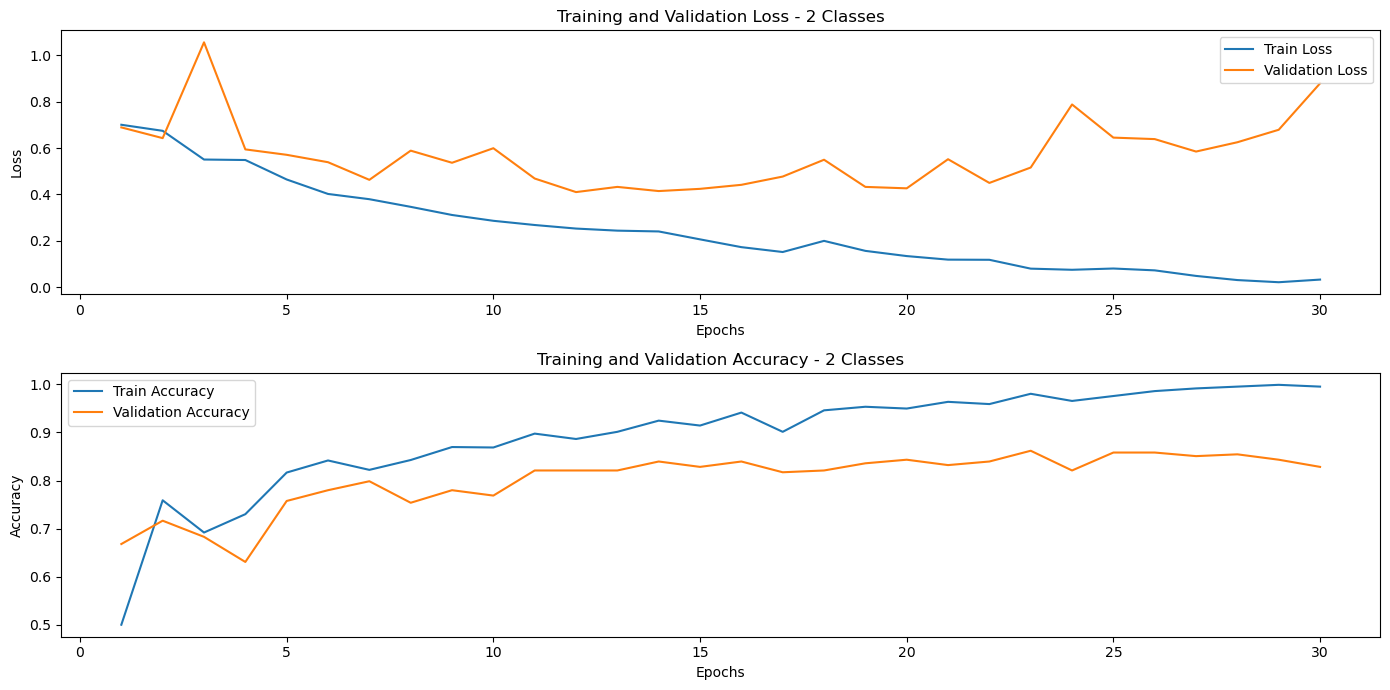

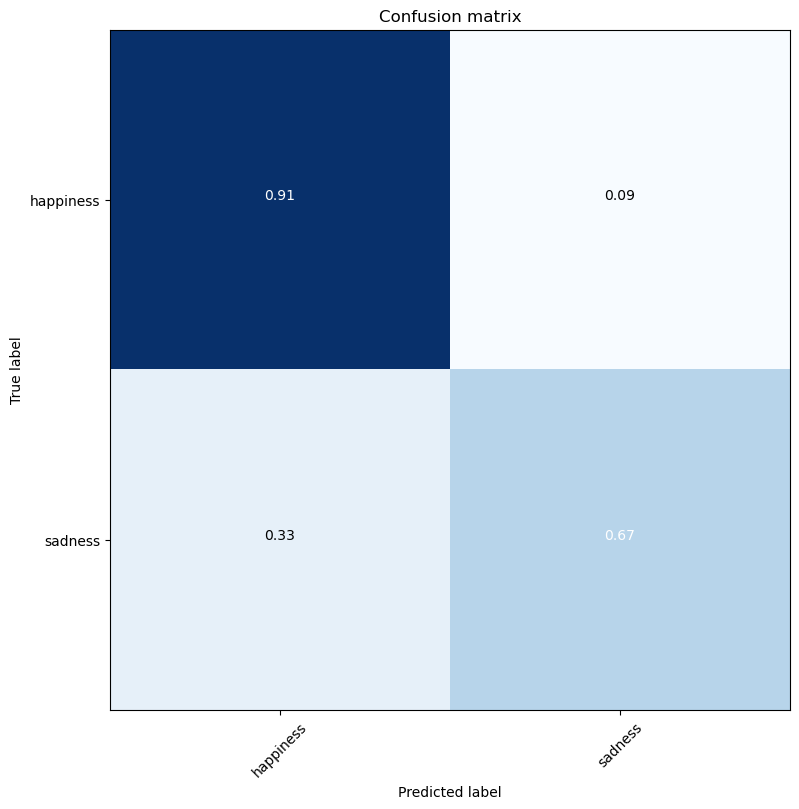

In [ ]:
use_cuda = True
num_classes = 2
combined_model = CombinedCNN(2).cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Epoch 20: Train Acc: 0.97, Train Loss: 0.1250 | Val Acc: 0.82, Val Loss: 0.6572
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch19
Epoch 21: Train Acc: 0.98, Train Loss: 0.0987 | Val Acc: 0.85, Val Loss: 0.5193
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch20
Epoch 22: Train Acc: 0.98, Train Loss: 0.1028 | Val Acc: 0.84, Val Loss: 0.6028
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch21
Epoch 23: Train Acc: 0.98, Train Loss: 0.0572 | Val Acc: 0.85, Val Loss: 0.6167
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch22
Epoch 24: Train Acc: 0.98, Train Loss: 0.0612 | Val Acc: 0.82, Val Loss: 0.8860
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch23
Epoch 25: Train Acc: 0.99, Train Loss: 0.0708 | Val Acc: 0.81, Val Loss: 0.6550
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch24
Epoch 26: Train Acc: 1.00, Train Loss: 0.0547 | Val Acc: 0.85, Val Loss: 0.7379
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch25
Epoch 27: Train Acc: 0.99, Train Loss: 0.0277 | Val Acc: 0.85, Val Loss: 0.7134
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch26
Epoch 28: Train Acc: 1.00, Train Loss: 0.0272 | Val Acc: 0.84, Val Loss: 0.7228
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch27
Epoch 29: Train Acc: 1.00, Train Loss: 0.0156 | Val Acc: 0.85, Val Loss: 0.9482
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch28
Epoch 30: Train Acc: 1.00, Train Loss: 0.0137 | Val Acc: 0.84, Val Loss: 0.8757
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr0.0005_epoch29
Finished Training
Total time elapsed: 76.92 seconds
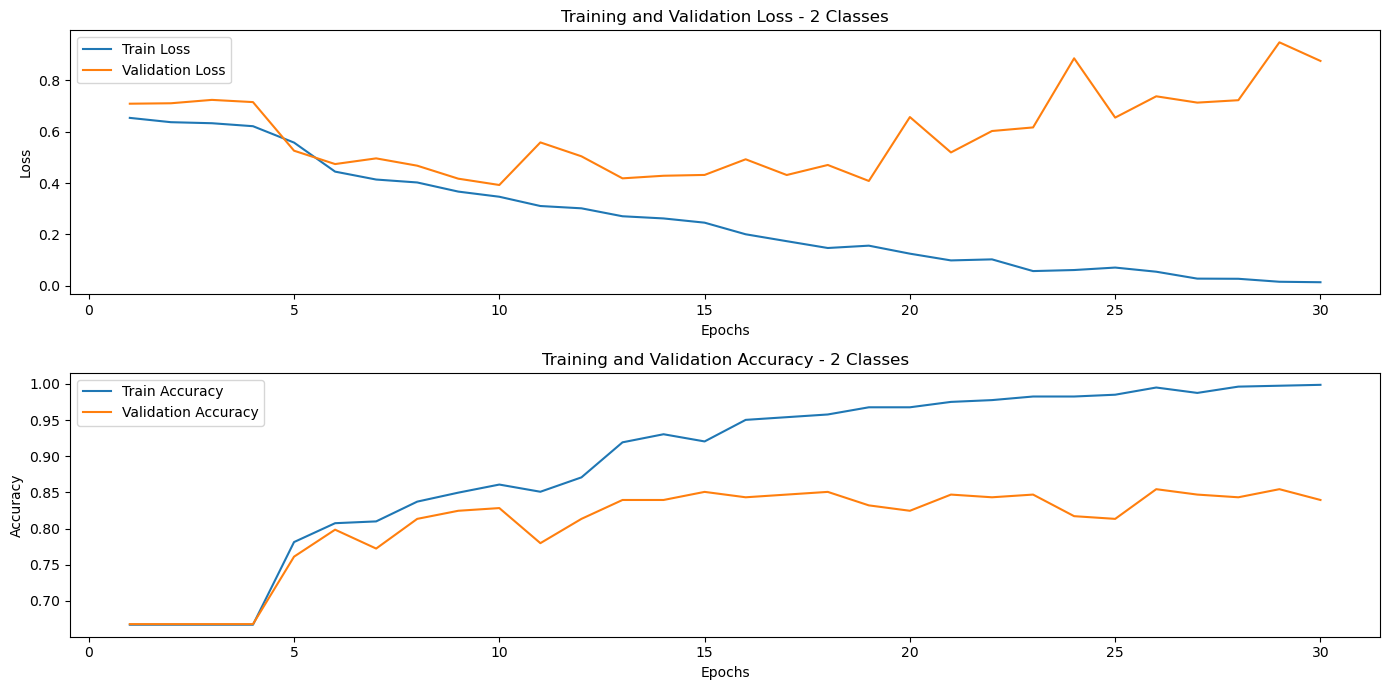
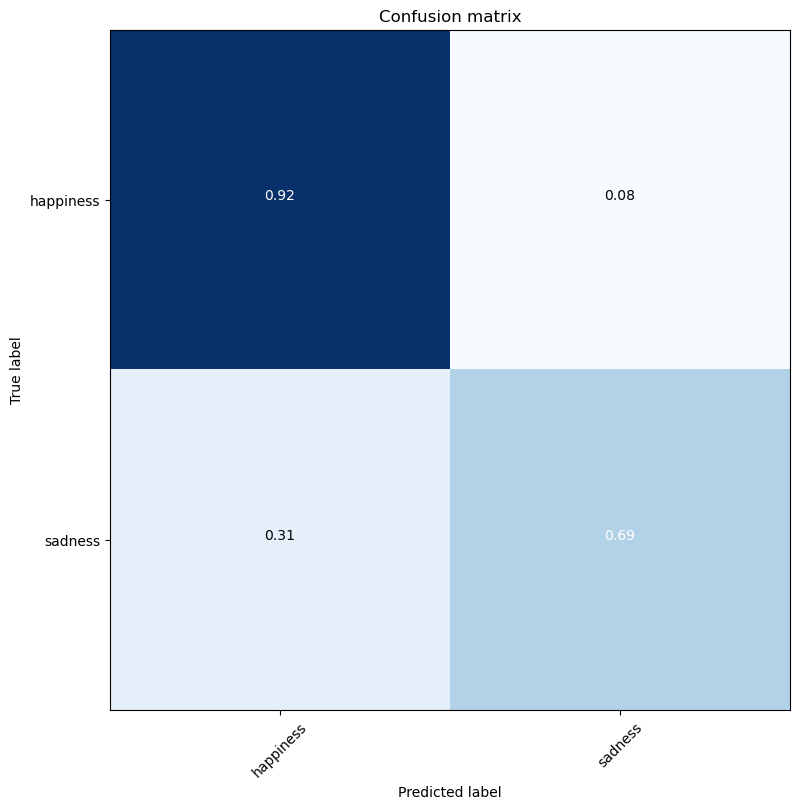

In [ ]:
use_cuda = True
num_classes = 2
combined_model = CNNetResidual3(2,16,16).cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=0.0005, num_epochs=30, num_classes=2)

Epoch 20: Train Acc: 1.00, Train Loss: 0.0152 | Val Acc: 0.82, Val Loss: 0.7495
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch19
Epoch 21: Train Acc: 1.00, Train Loss: 0.0178 | Val Acc: 0.81, Val Loss: 0.8303
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch20
Epoch 22: Train Acc: 1.00, Train Loss: 0.0111 | Val Acc: 0.82, Val Loss: 0.7300
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch21
Epoch 23: Train Acc: 1.00, Train Loss: 0.0060 | Val Acc: 0.82, Val Loss: 0.8118
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch22
Epoch 24: Train Acc: 1.00, Train Loss: 0.0038 | Val Acc: 0.82, Val Loss: 0.9497
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch23
Epoch 25: Train Acc: 1.00, Train Loss: 0.0019 | Val Acc: 0.82, Val Loss: 0.8780
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch24
Epoch 26: Train Acc: 1.00, Train Loss: 0.0017 | Val Acc: 0.82, Val Loss: 0.8724
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch25
Epoch 27: Train Acc: 1.00, Train Loss: 0.0027 | Val Acc: 0.82, Val Loss: 0.8748
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch26
Epoch 28: Train Acc: 1.00, Train Loss: 0.0051 | Val Acc: 0.82, Val Loss: 0.7659
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch27
Epoch 29: Train Acc: 1.00, Train Loss: 0.0052 | Val Acc: 0.78, Val Loss: 1.2444
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch28
Epoch 30: Train Acc: 1.00, Train Loss: 0.0086 | Val Acc: 0.82, Val Loss: 0.8264
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr0.0005_epoch29
Finished Training
Total time elapsed: 44.71 seconds
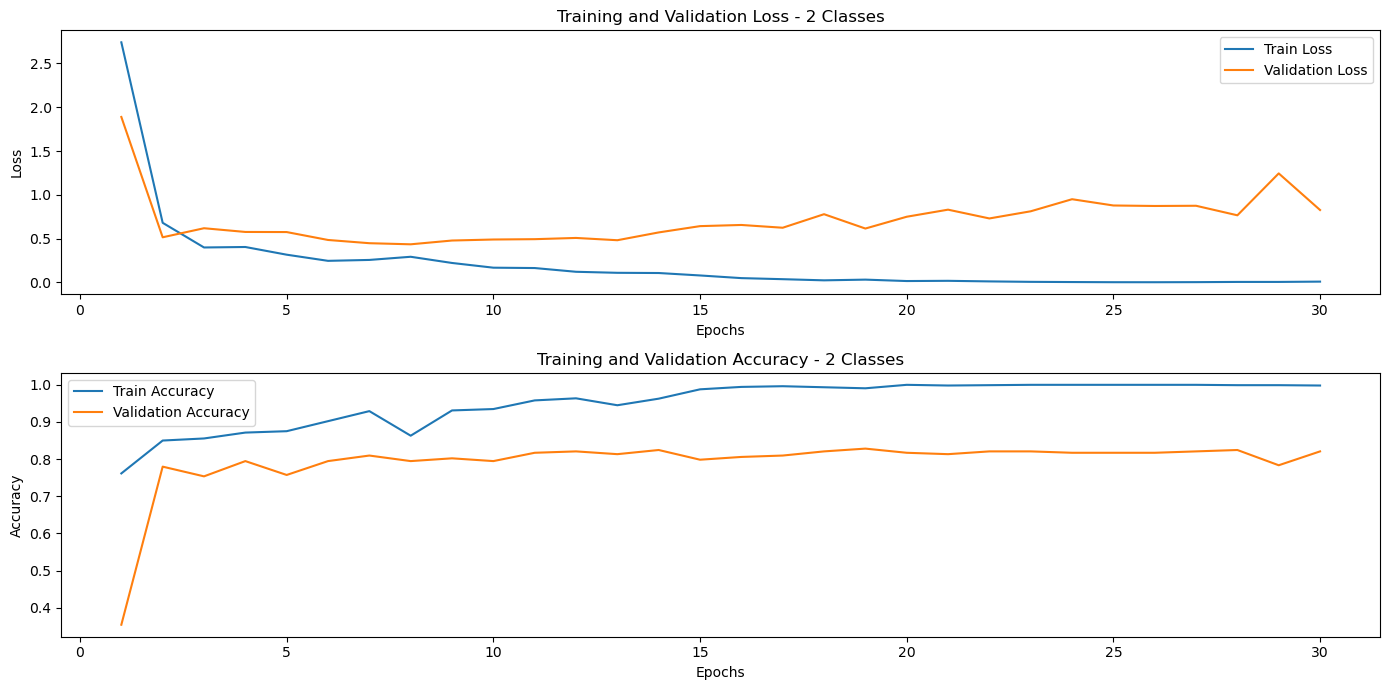
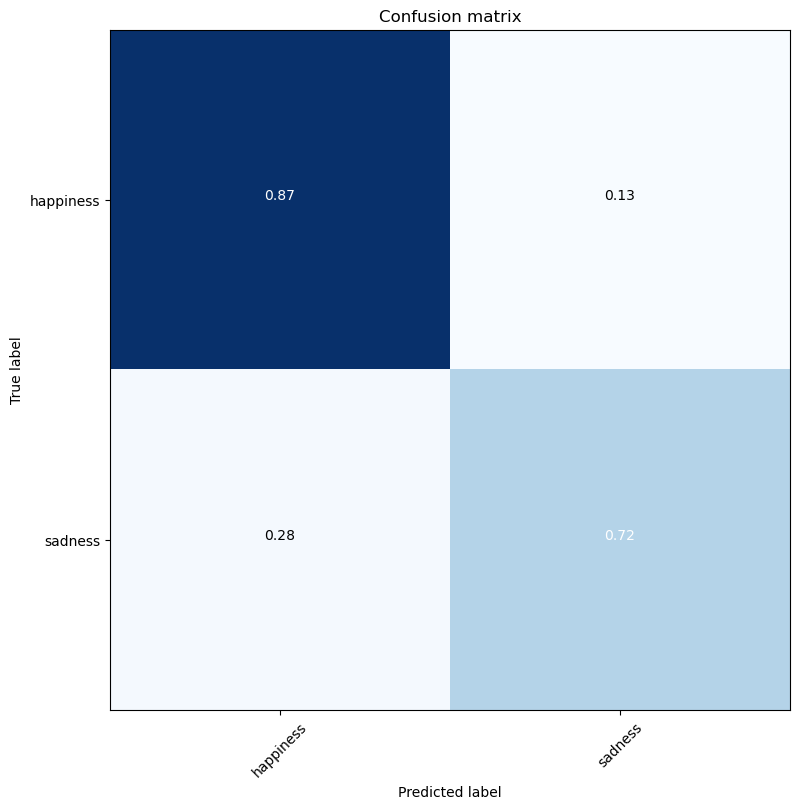

In [47]:
def testevaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    model.eval()  # Set the model to evaluation mode

    for inputs, labels in loader:
        inputs = inputs.unsqueeze(0)
        inputs = inputs.cuda()  # Move inputs to GPU
        labels = labels.cuda()  # Move labels to GPU

        outputs = model(inputs)
        predicted = outputs.max(1, keepdim=True)[1]
        total += inputs.shape[0]
        correct += predicted.eq(labels.view_as(predicted)).sum().item()


    model.train()  # Set the model back to training mode
    return correct / total

In [49]:
# # load your best model
# best_model2class = CombinedCNN(2)
# best_model2class.load_state_dict(torch.load('C:/Users/Admin/Desktop/MIE1517_Project/output/model_CombinedCNN_bs64_lr0.0005_epoch29.pt'))

<All keys matched successfully>

In [50]:
# best_model2class.cuda()
# eval_value,_,_ = evaluate(best_model2class, combined_test_dataset)
# print("Test Acc :", eval_value)

Test Acc : 0.8708487084870848


## 4 Classes

In [35]:
# Three class sadness, happiness, anger
features_or_array = np.array(features_or)  # Convert features to a NumPy array for indexing
labels_or_array = np.array(labels_or)  # Convert labels to a NumPy array for indexing
# Define the labels you want to extract
desired_labels = [0, 4, 6, 7]

# Create a mask to filter the indices corresponding to the desired labels
mask = np.isin(labels_or_array, desired_labels)

# Extract features and labels corresponding to the desired labels
features_filtered = features_or_array[mask]
labels_filtered = labels_or_array[mask]
# Verify the shapes and sizes of the extracted features and labels
label_counts_or_filtered = Counter(labels_filtered)
for label, count in label_counts_or_filtered.items():
    print(f"Label {label} {classeses[label]}: {count} images")
print("Filtered Features Shape:", features_filtered.shape)
print("Filtered Labels Shape:", labels_filtered.shape)

Label 0 anger: 585 images
Label 4 happiness: 896 images
Label 6 sadness: 448 images
Label 7 surprise: 600 images
Filtered Features Shape: (2529, 224, 224)
Filtered Labels Shape: (2529,)


In [36]:
labels_filtered = np.array(labels_filtered)

# Change value 1 to 0 and value 5 to 1
labels_filtered[labels_filtered == 0] = 0
labels_filtered[labels_filtered == 4] = 1
labels_filtered[labels_filtered == 6] = 2
labels_filtered[labels_filtered == 7] = 3
np.unique(labels_filtered)

array([0, 1, 2, 3])

In [37]:
# Prepare datasets for eyes, eyebrows, and mouth
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_filtered, labels_filtered, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (anger): 537 images
Label 1 (contempt): 537 images
Label 2 (disgust): 537 images
Label 3 (fear): 537 images


In [ ]:
use_cuda = True
num_classes = 4
combined_model = CombinedCNN(4).cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=1e-5, num_epochs=60, num_classes=4)

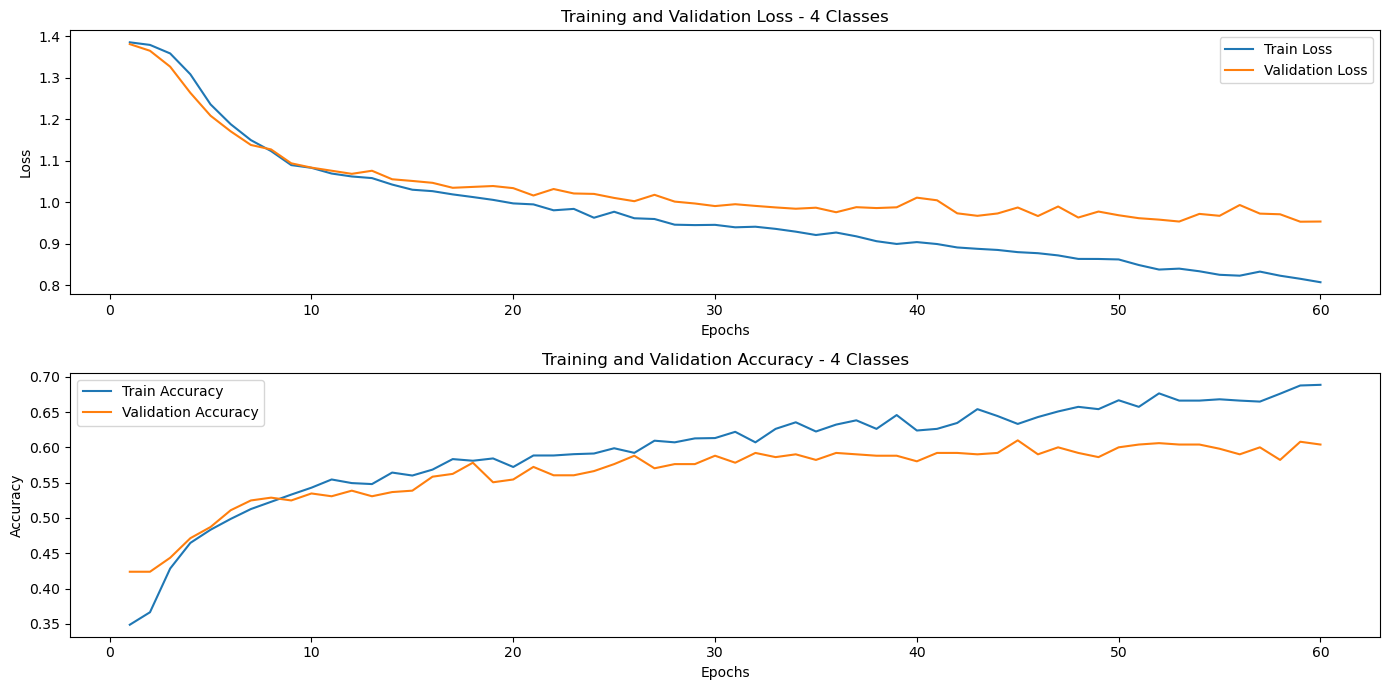
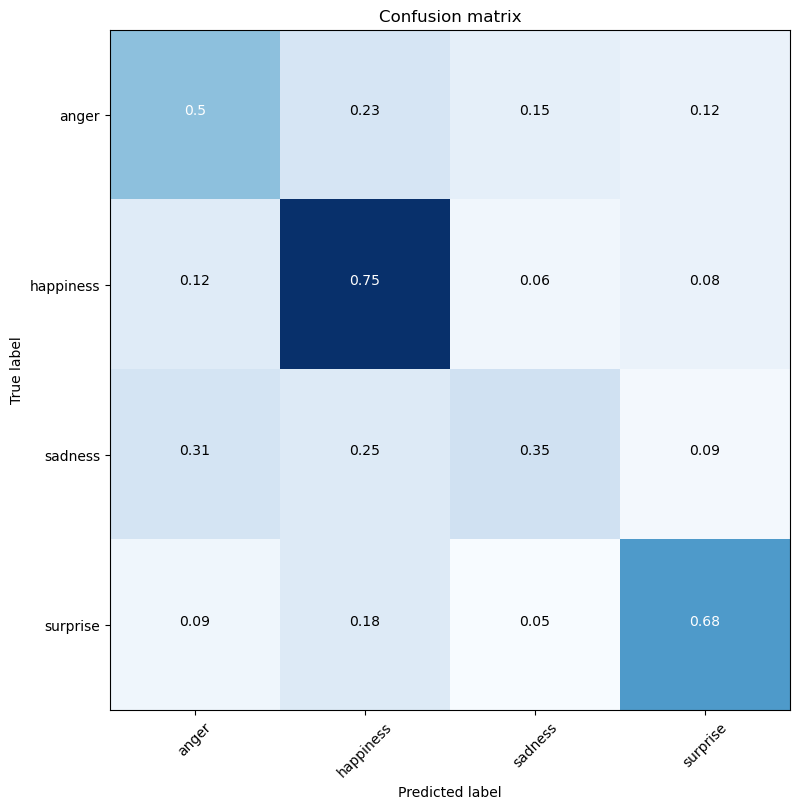
Epoch 40: Train Acc: 0.62, Train Loss: 0.9037 | Val Acc: 0.58, Val Loss: 1.0108
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch39
Epoch 41: Train Acc: 0.63, Train Loss: 0.8990 | Val Acc: 0.59, Val Loss: 1.0045
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch40
Epoch 42: Train Acc: 0.63, Train Loss: 0.8908 | Val Acc: 0.59, Val Loss: 0.9731
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch41
Epoch 43: Train Acc: 0.65, Train Loss: 0.8875 | Val Acc: 0.59, Val Loss: 0.9671
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch42
Epoch 44: Train Acc: 0.64, Train Loss: 0.8848 | Val Acc: 0.59, Val Loss: 0.9727
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch43
Epoch 45: Train Acc: 0.63, Train Loss: 0.8795 | Val Acc: 0.61, Val Loss: 0.9871
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch44
Epoch 46: Train Acc: 0.64, Train Loss: 0.8770 | Val Acc: 0.59, Val Loss: 0.9665
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch45
Epoch 47: Train Acc: 0.65, Train Loss: 0.8716 | Val Acc: 0.60, Val Loss: 0.9895
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch46
Epoch 48: Train Acc: 0.66, Train Loss: 0.8632 | Val Acc: 0.59, Val Loss: 0.9629
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch47
Epoch 49: Train Acc: 0.65, Train Loss: 0.8631 | Val Acc: 0.59, Val Loss: 0.9773
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch48
Epoch 50: Train Acc: 0.67, Train Loss: 0.8619 | Val Acc: 0.60, Val Loss: 0.9684
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch49
Epoch 51: Train Acc: 0.66, Train Loss: 0.8484 | Val Acc: 0.60, Val Loss: 0.9613
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch50
Epoch 52: Train Acc: 0.68, Train Loss: 0.8375 | Val Acc: 0.61, Val Loss: 0.9579
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch51
Epoch 53: Train Acc: 0.67, Train Loss: 0.8398 | Val Acc: 0.60, Val Loss: 0.9533
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch52
Epoch 54: Train Acc: 0.67, Train Loss: 0.8334 | Val Acc: 0.60, Val Loss: 0.9717
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch53
Epoch 55: Train Acc: 0.67, Train Loss: 0.8249 | Val Acc: 0.60, Val Loss: 0.9671
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch54
Epoch 56: Train Acc: 0.67, Train Loss: 0.8228 | Val Acc: 0.59, Val Loss: 0.9931
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch55
Epoch 57: Train Acc: 0.66, Train Loss: 0.8326 | Val Acc: 0.60, Val Loss: 0.9723
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch56
Epoch 58: Train Acc: 0.68, Train Loss: 0.8227 | Val Acc: 0.58, Val Loss: 0.9708
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch57
Epoch 59: Train Acc: 0.69, Train Loss: 0.8153 | Val Acc: 0.61, Val Loss: 0.9528
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch58
Epoch 60: Train Acc: 0.69, Train Loss: 0.8070 | Val Acc: 0.60, Val Loss: 0.9533
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch59

Training Begin...

Epoch 1: Train Acc: 0.35, Train Loss: 1.3729 | Val Acc: 0.35, Val Loss: 1.3606
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.35, Train Loss: 1.3545 | Val Acc: 0.35, Val Loss: 1.3520
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.35, Train Loss: 1.3504 | Val Acc: 0.35, Val Loss: 1.3495
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.35, Train Loss: 1.3493 | Val Acc: 0.35, Val Loss: 1.3460
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.35, Train Loss: 1.3452 | Val Acc: 0.35, Val Loss: 1.3390
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.35, Train Loss: 1.3356 |

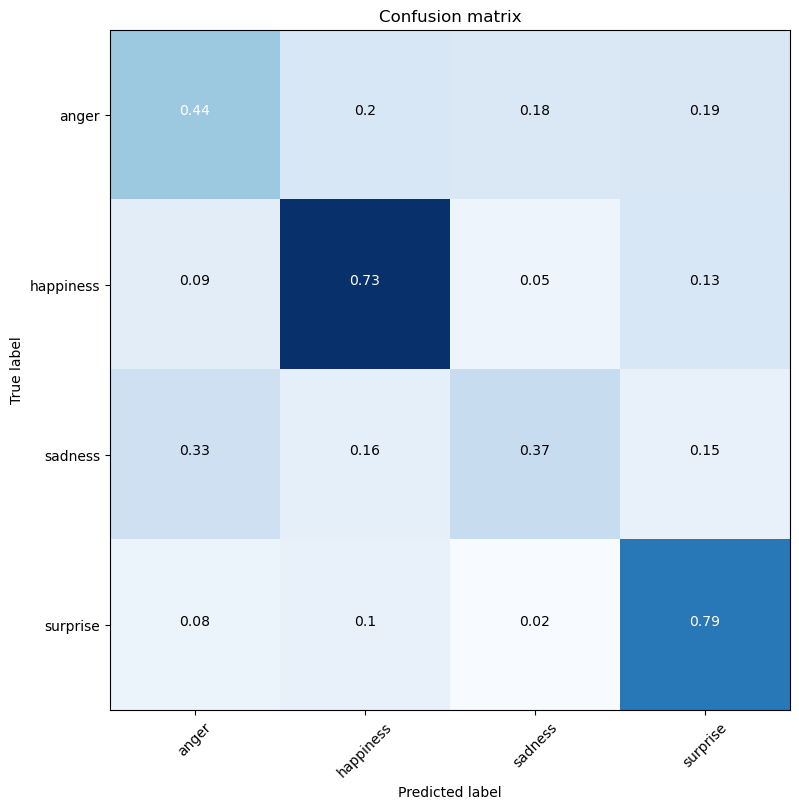

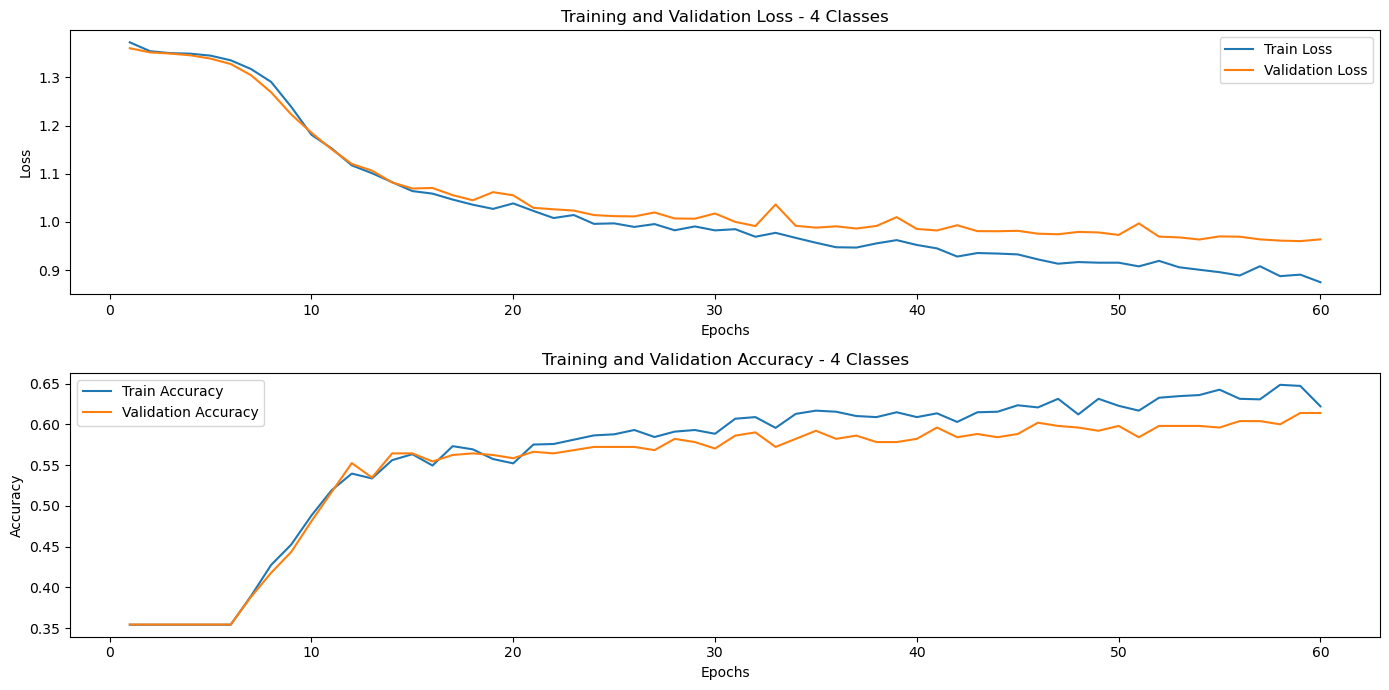

In [17]:
use_cuda = True
num_classes = 4
combined_model = CombinedCNN(4).cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=60, num_classes=4)

Training Begin...

Epoch 1: Train Acc: 0.57, Train Loss: 1.2162 | Val Acc: 0.55, Val Loss: 1.1000
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.62, Train Loss: 1.0129 | Val Acc: 0.56, Val Loss: 1.0521
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.62, Train Loss: 0.9213 | Val Acc: 0.58, Val Loss: 1.0263
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.67, Train Loss: 0.8744 | Val Acc: 0.60, Val Loss: 0.9990
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.71, Train Loss: 0.8230 | Val Acc: 0.62, Val Loss: 0.9762
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.75, Train

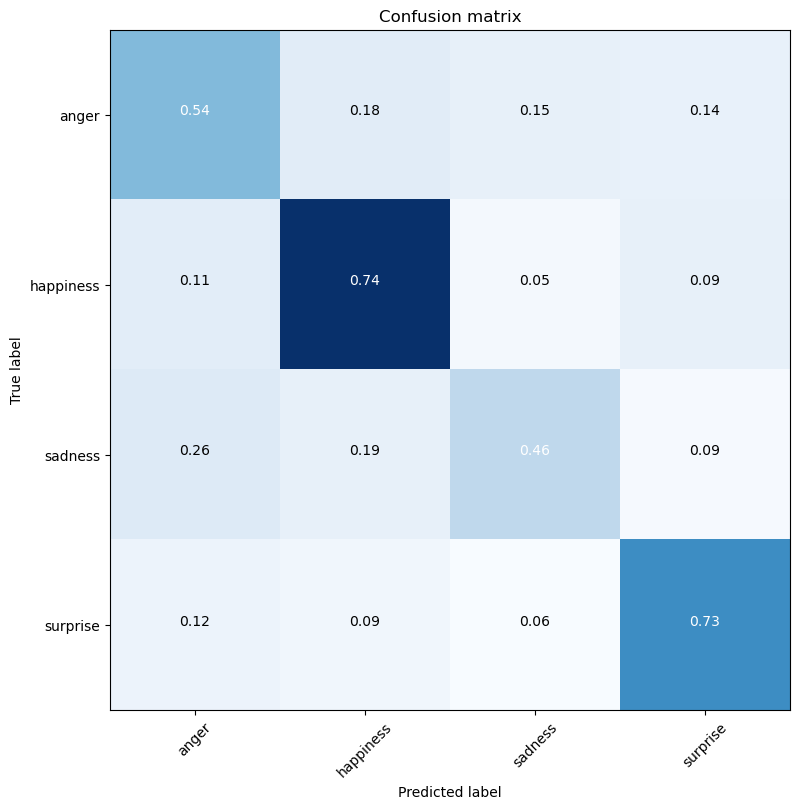

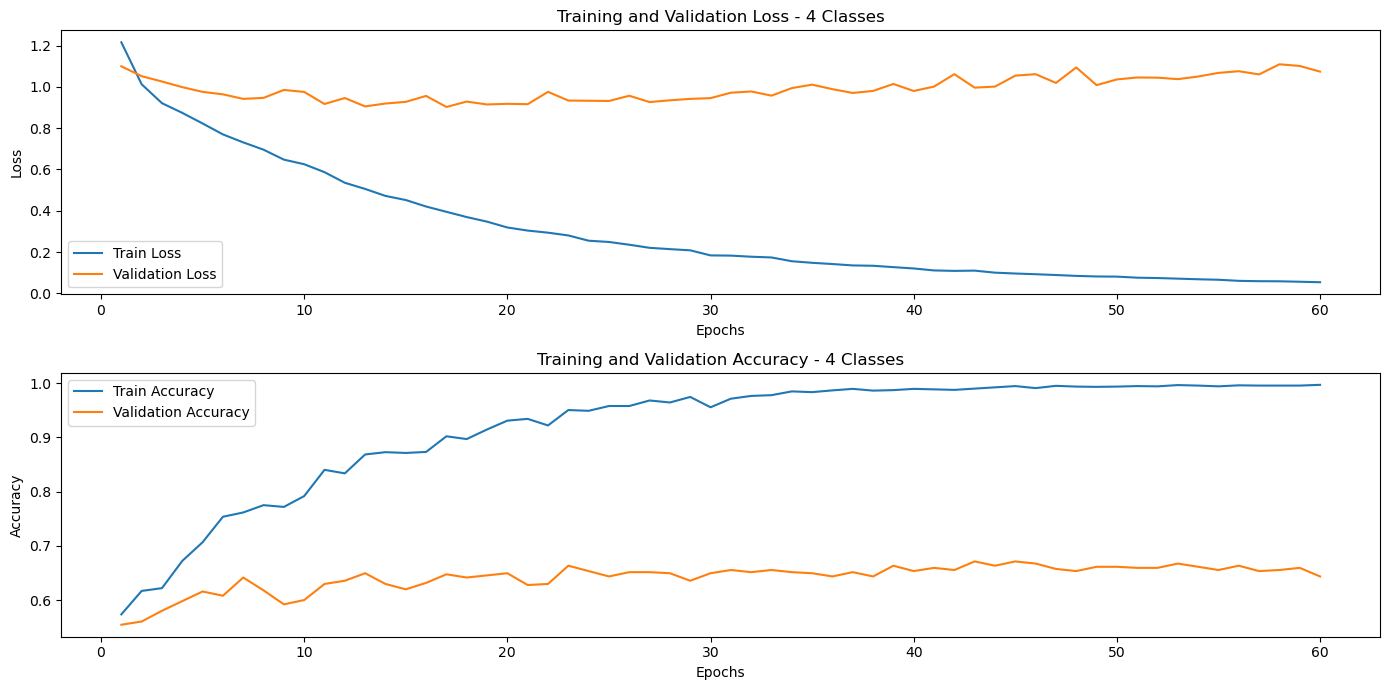

In [38]:
use_cuda = True
num_classes = 4
combined_model = CNNetResidual3(4,16,16).cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=1e-5, num_epochs=60, num_classes=4)

In [39]:
best_model2class = CNNetResidual3(4,16,16)
best_model2class.load_state_dict(torch.load("C:/Users/Admin/Desktop/MIE1517_Project/output/model_CNNetResidual3_bs64_lr1e-05_epoch52.pt"))

<All keys matched successfully>

In [40]:
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)
best_model2class.cuda()
use_cuda = True
eval_value,_,_ = evaluate(best_model2class, Combined_test_loader)
print("Test Acc:", eval_value)

Test Acc: 0.6082677165354331


## 8 Classes

In [20]:
# Prepare datasets for eyes, eyebrows, and mouth
features_all = np.array(features_or)
labels_all = np.array(labels_or)
combined_train_dataset, combined_val_dataset, combined_test_dataset = split_and_prepare_dataset(features_all, labels_all, transform)

# Balance the train data
balanced_train_dataset = balance_dataset_with_augmentation(combined_train_dataset, augmentation_transforms)
balanced_train_labels = balanced_train_dataset.tensors[1].numpy()
# Count the number of images for each unique label in the balanced dataset
label_counts_balanced = Counter(balanced_train_labels)
# Print the counts for each label
for label, count in label_counts_balanced.items():
    print(f"Label {label} ({classes[label]}): {count} images")

Label 0 (anger): 537 images
Label 1 (contempt): 537 images
Label 2 (disgust): 537 images
Label 3 (fear): 537 images
Label 4 (happiness): 537 images
Label 5 (neutrality): 537 images
Label 6 (sadness): 537 images
Label 7 (surprise): 537 images


Training Begin...

Epoch 1: Train Acc: 0.18, Train Loss: 2.0779 | Val Acc: 0.23, Val Loss: 2.0645
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.19, Train Loss: 2.0642 | Val Acc: 0.28, Val Loss: 2.0140
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.25, Train Loss: 2.0146 | Val Acc: 0.31, Val Loss: 1.9208
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.26, Train Loss: 1.9324 | Val Acc: 0.30, Val Loss: 1.8838
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.29, Train Loss: 1.8879 | Val Acc: 0.32, Val Loss: 1.7893
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.29, Train Loss: 1.8495 |

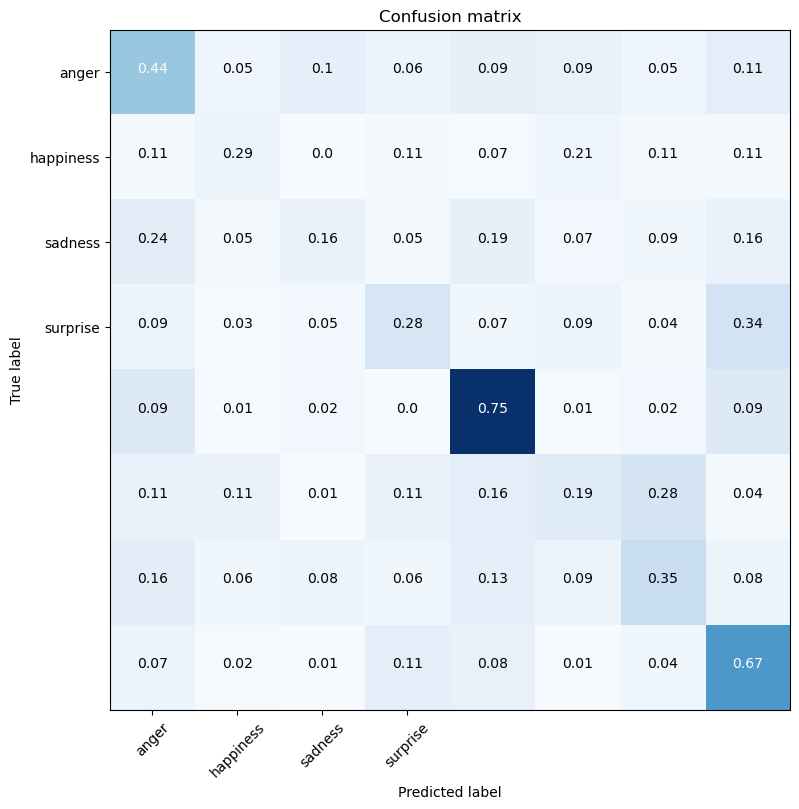

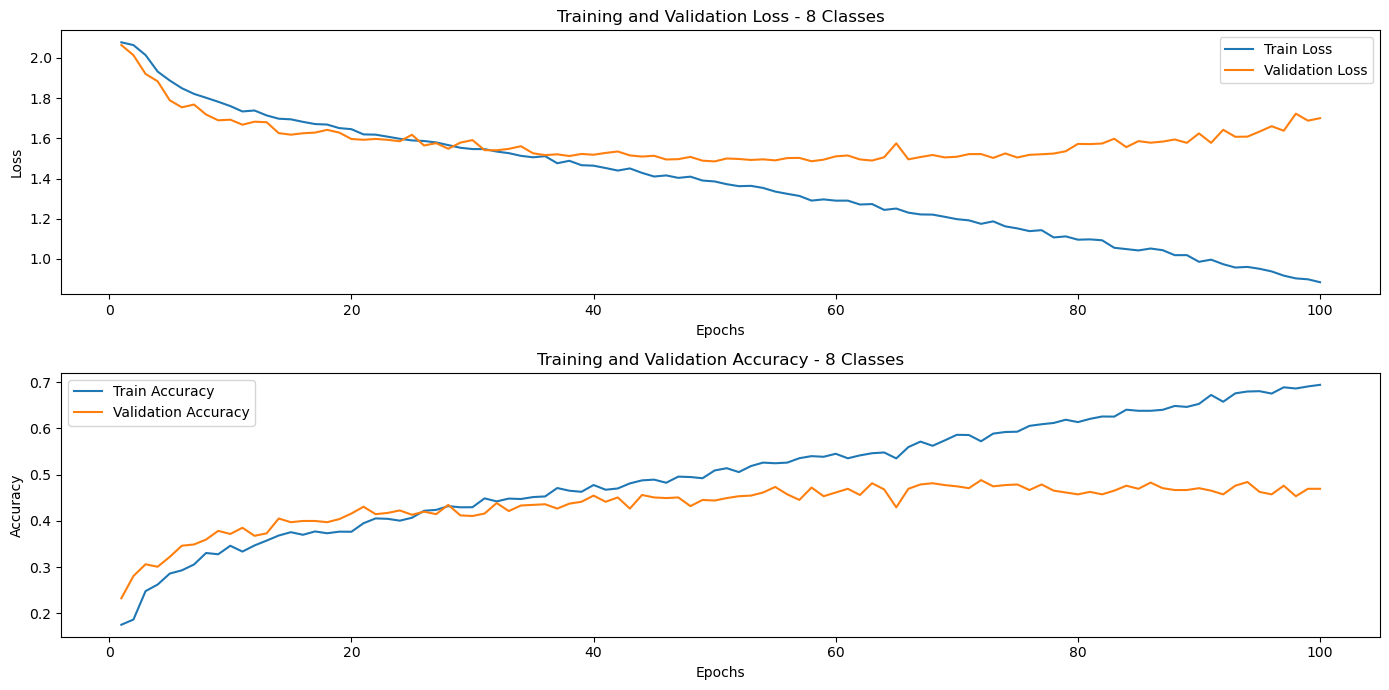

In [21]:
use_cuda = True
num_classes = 8
combined_model = CombinedCNN(8).cuda()
Model1 = trainmodel(combined_model, balanced_train_dataset, combined_val_dataset, batch=64, learningRate=1e-5, num_epochs=100, num_classes=8)

Training Begin...

Epoch 1: Train Acc: 0.24, Train Loss: 2.0553 | Val Acc: 0.24, Val Loss: 2.0220
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.24, Train Loss: 1.9915 | Val Acc: 0.24, Val Loss: 1.9664
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.24, Train Loss: 1.9791 | Val Acc: 0.24, Val Loss: 1.9610
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.24, Train Loss: 1.9694 | Val Acc: 0.24, Val Loss: 1.9562
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.24, Train Loss: 1.9636 | Val Acc: 0.24, Val Loss: 1.9451
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CombinedCNN_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.26, Train Loss: 1.9559 |

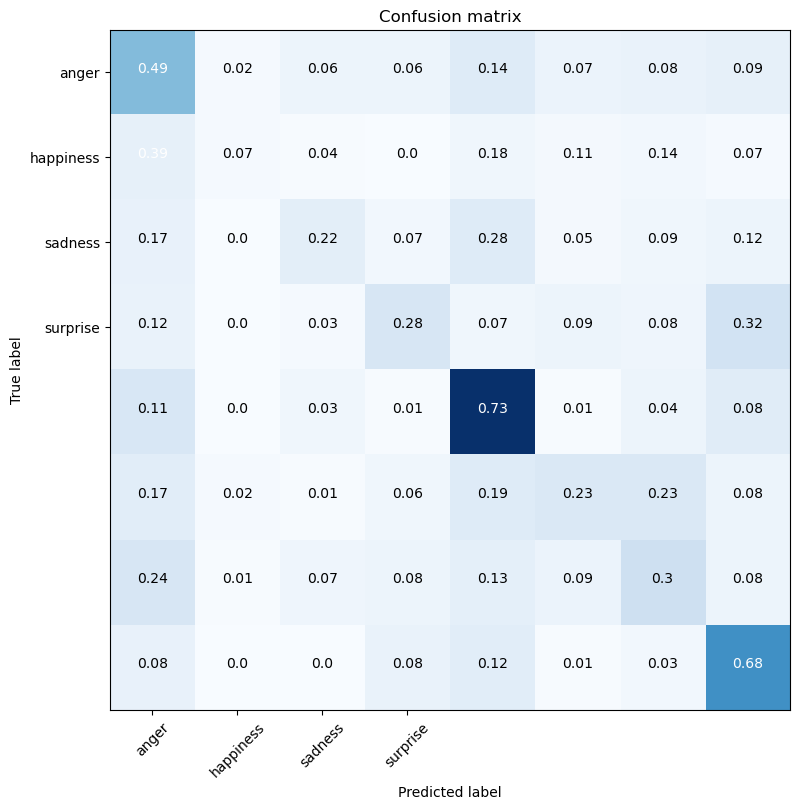

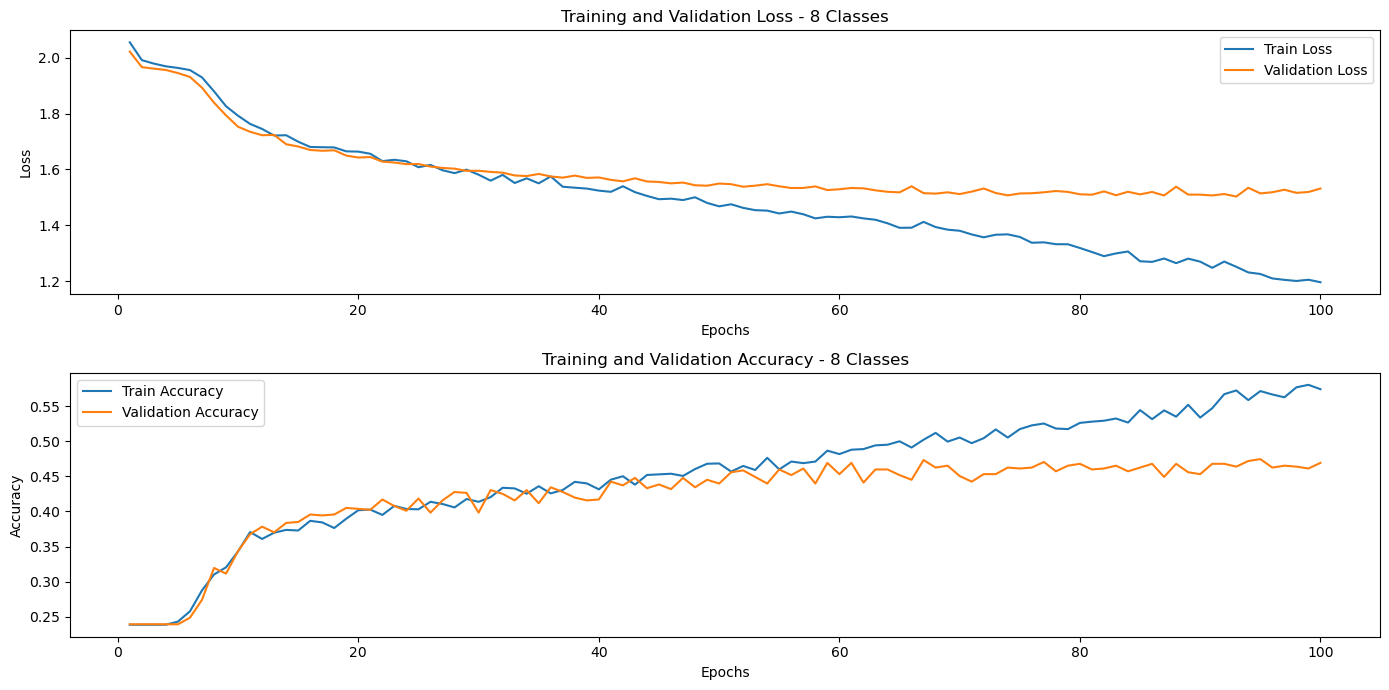

In [22]:
use_cuda = True
num_classes = 8
combined_model = CombinedCNN(8).cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=0.00001, num_epochs=100, num_classes=8)

Training Begin...

Epoch 1: Train Acc: 0.38, Train Loss: 1.8297 | Val Acc: 0.35, Val Loss: 1.7188
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch0
Epoch 2: Train Acc: 0.43, Train Loss: 1.6535 | Val Acc: 0.41, Val Loss: 1.6371
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch1
Epoch 3: Train Acc: 0.47, Train Loss: 1.5764 | Val Acc: 0.43, Val Loss: 1.6112
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch2
Epoch 4: Train Acc: 0.49, Train Loss: 1.4900 | Val Acc: 0.43, Val Loss: 1.5891
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch3
Epoch 5: Train Acc: 0.52, Train Loss: 1.4233 | Val Acc: 0.45, Val Loss: 1.5666
Saved model checkpoint: C:/Users/Admin/Desktop/MIE1517_Project/output\model_CNNetResidual3_bs64_lr1e-05_epoch4
Epoch 6: Train Acc: 0.56, Train

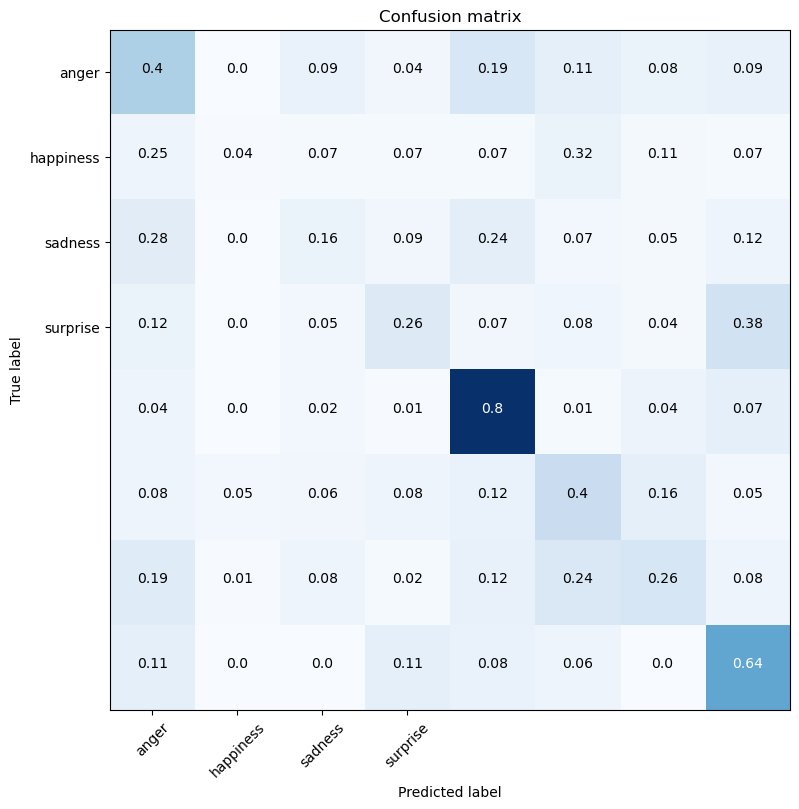

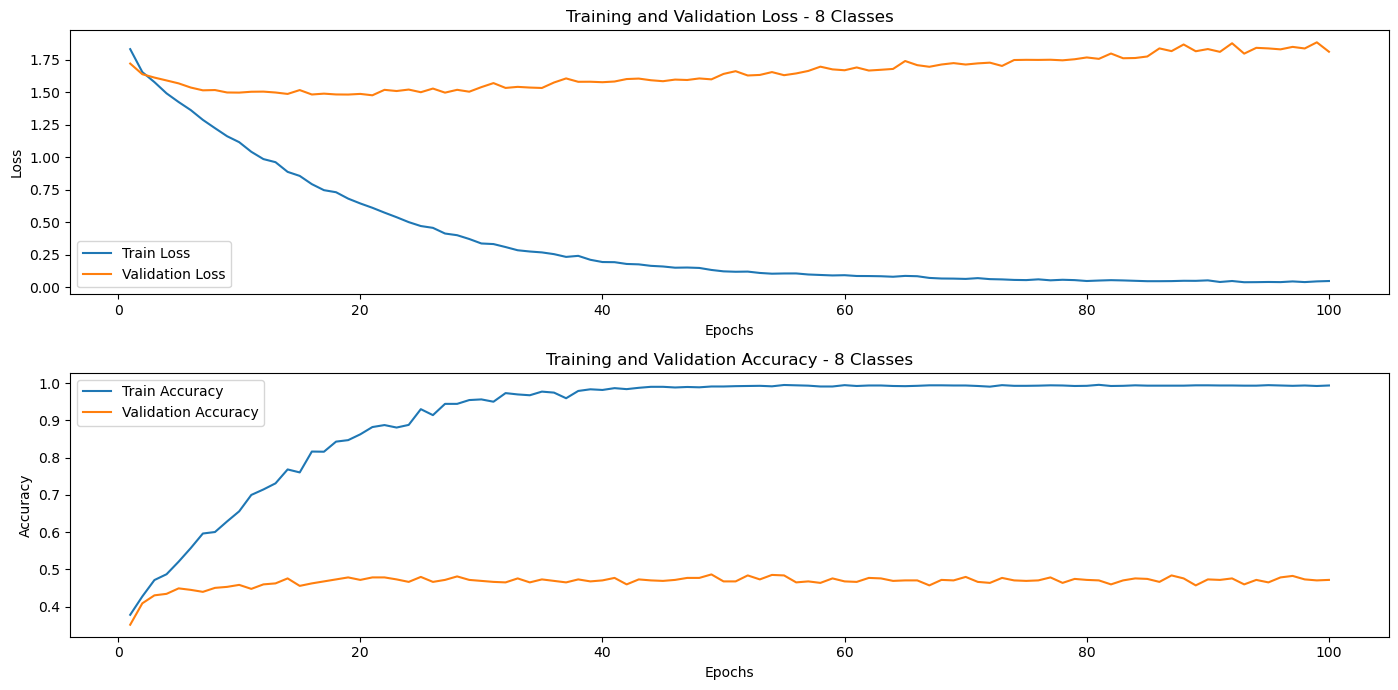

In [24]:
use_cuda = True
num_classes = 8
combined_model = CNNetResidual3(8,32,32).cuda()
Model1 = trainmodel(combined_model, combined_train_dataset, combined_val_dataset, batch=64, learningRate=1e-5, num_epochs=100, num_classes=8)

In [31]:
best_model8class = CNNetResidual3(8,32,32)
best_model8class.load_state_dict(torch.load("C:/Users/Admin/Desktop/MIE1517_Project/output/model_CNNetResidual3_bs64_lr1e-05_epoch96.pt"))

<All keys matched successfully>

In [34]:
Combined_test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)
best_model8class.cuda()
use_cuda = True
eval_value,_,_ = evaluate(best_model8class, Combined_test_loader)
print("Test Acc:", eval_value)

Test Acc: 0.39814814814814814
